In [29]:
import sys
sys.path.append('/home/emastr/phd/')
import pygmsh as pg
import dolfin as dl
import mshr as ms
import numpy as np
import matplotlib.pyplot as plt
from hmm.stokes_fenics import StokesMacProb, StokesData, MacroSol, MacroSolver, StokesMicProb, MicroSolver, StokesHMMProblem, macro_to_micro, micros_to_macro
from hmm.hmm import IterativeHMMSolver
from util.basis_scaled import FourBasis, ScaleShiftedBasis
from util.mesh_tools import Box, order_connected_vertices, boundary_bbox_tree, find_intersection_on_segment, plot_boundary_mesh
from util.random import smooth_random_loop_fourier_coef, fourierGP_2D_lerp
from util.logger import EventTracker
from util.plot_tools import remove_axes
from dataclasses import dataclass
import meshio
import gmsh
from hmm.stokes_deep import DeepMicroSolverFenics, get_net
from typing import List, Tuple, Callable, Dict, Optional, Union

np.random.seed(0)
MESH_PATH = "/home/emastr/phd/data/mesh/"

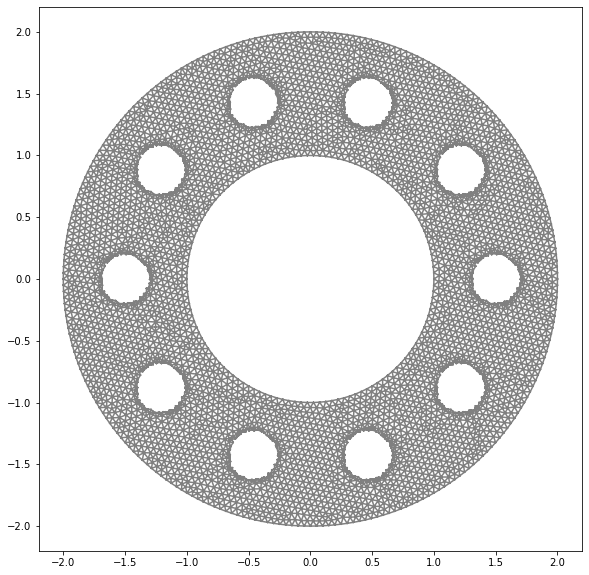

In [30]:
def list_sum(lists):
    return [item for sublist in lists for item in sublist]

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

with pg.geo.Geometry() as geom:
    N_ = 500
    
    t = np.linspace(0, 2*np.pi, N_+1)[:-1]
    x = np.cos(t)
    y = np.sin(t)
    r = 0.2 + 0.01 * np.random.randn(len(t))#np.sin(20*t)
    
    M = 10
    blob_x = np.cos(np.linspace(0, 2*np.pi, M+1)[:-1])*1.5
    blob_y = np.sin(np.linspace(0, 2*np.pi, M+1)[:-1])*1.5
    
    points_inner = []
    points_outer = []
    insets = []
    
    for n in range(len(t)):
        points_inner.append(geom.add_point([x[n], y[n]]))
        points_outer.append(geom.add_point([2.*x[n], 2.*y[n]]))
    
    for m in range(M):
        tmp = []
        for n in list(range(len(t)))[::-1]:
            tmp.append(geom.add_point([r[n]*x[n] + blob_x[m], r[n]*y[n] + blob_y[m]]))
        s1 = geom.add_bspline(tmp[0:N_//2+1])
        s2 = geom.add_bspline(tmp[N_//2:] + [tmp[0]])
        l_inset  = geom.add_curve_loop([s1, s2])    
        insets.append(l_inset)
    
    
    #s1 = geom.add_bspline(points_inner[0:N_//2+1])
    #s2 = geom.add_bspline(points_inner[N_//2:] + [points_inner[0]])
    l_inner  = geom.add_circle([0, 0], 1)    
    l_outer  = geom.add_circle([0,0], 2.) #geom.add_curve_loop([s1, s2])
    
    surf = geom.add_plane_surface(l_outer.curve_loop, holes=[l_inner.curve_loop] + insets)#, l_inset])
    geom.add_physical(l_outer.curve_loop.curves + l_inner.curve_loop.curves + list_sum([g.curves for g in insets]), label="Dirichlet")
    geom.add_physical(surf, label='Inside')
    
    geom.set_mesh_size_callback(lambda dim, tag, x, y, z, lc: 5e-2)
    mesh = geom.generate_mesh(dim=2)
    gmsh.write(f'{MESH_PATH}temp.msh')        
    
    mesh = meshio.read(f'{MESH_PATH}temp.msh')    
    mesh = create_mesh(mesh, "triangle", True)
    meshio.write(f'{MESH_PATH}temp.xdmf', mesh) 
    
file = dl.XDMFFile(f'{MESH_PATH}temp.xdmf')
mesh = dl.Mesh()
file.read(mesh)


plt.figure(figsize=(10,10))
dl.plot(mesh)

# print(mesh.Edge)
#plt.scatter(mesh.points[:,0], mesh.points[:,1])
#dl.plot(mesh)
#dl.plot(mesh)